In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils', '../utils', '../utils']


In [9]:
import yaml

config_path = 'config_linear_1000_100.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [10]:
save_dir = config['save_dir']
data_dir = config['data_dir']

train_loss = np.load(os.path.join(save_dir, 'train_losses.npy'))
test_loss = np.load(os.path.join(save_dir, 'test_losses.npy'))


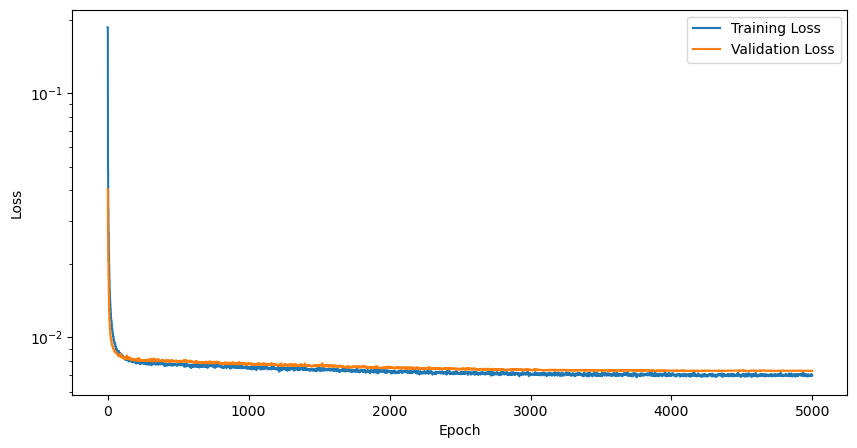

In [11]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [12]:
import pca_koopman_dir as km
import torch
# Device
device = 'cpu'
print('Device:', device)

# todo: multi nu
nu = config['nu']
nu_list = [nu]

# Data loader
x_data, u_data, nu_data, n_features, n_inputs = data_preparation_xu(config, nu_list, nu)

# Params
params = km.Params(n_features, n_inputs, config)

# Model
model = km.build_model(params, x_data, u_data)
model = model.to(device)

Device: cpu


In [13]:
model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth'), map_location=device))

<All keys matched successfully>

In [14]:

# Data preparation
x_dataset = []
u_dataset = []
window_size = config['window_size']


for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, _, u_data, _ = load_dataset(data_dict)
        x_dataset.append(x_data[:window_size,:])
        u_dataset.append(u_data[:window_size,:])
    else:
        print(f"File not found: {data_file_path}")

In [15]:
len(x_dataset)

49

In [16]:
# start from the zero point
nu = torch.tensor([1000])
x_data_pred_traj = []
x_data_pca_traj = []
x_data_pca_pred_traj = []
nu = torch.tensor(build_nu(nu_list, 1, nu), dtype=torch.int16)
nu = nu.reshape((1, -1))
for x_data, u_data in zip(x_dataset, u_dataset):
    steps = window_size    

    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
    x_pred = torch.zeros_like(x_data).to(device)
    x_pred[0, :] = x_data[0, :]
    x0 = model.encode(x_data[0, :].reshape(1, -1))
    x0 = model.state_dic(x0)
    for step in range(1, steps):
        u = u_data[step-1, :].reshape(1, -1)
        x1 = model.latent_to_latent_forward(x0, u, nu)
        x_pred[step, :] = model.decode(x1)
        x0 = x1
    x_data_pred_traj.append(x_pred.detach().cpu().numpy())

    x_pca_true = model.std_layer_1.transform(x_data.detach())
    x_pca_true = model.pca_transformer.transform(x_pca_true)
    x_pca_pred = model.std_layer_1.transform(x_pred.detach())
    x_pca_pred = model.pca_transformer.transform(x_pca_pred)
    x_data_pca_traj.append(x_pca_true)
    x_data_pca_pred_traj.append(x_pca_pred)
        



In [17]:
errors = [x_data_pred_traj[i] - x_dataset[i][:window_size, :] for i in range(len(x_data_pred_traj))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

In [18]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

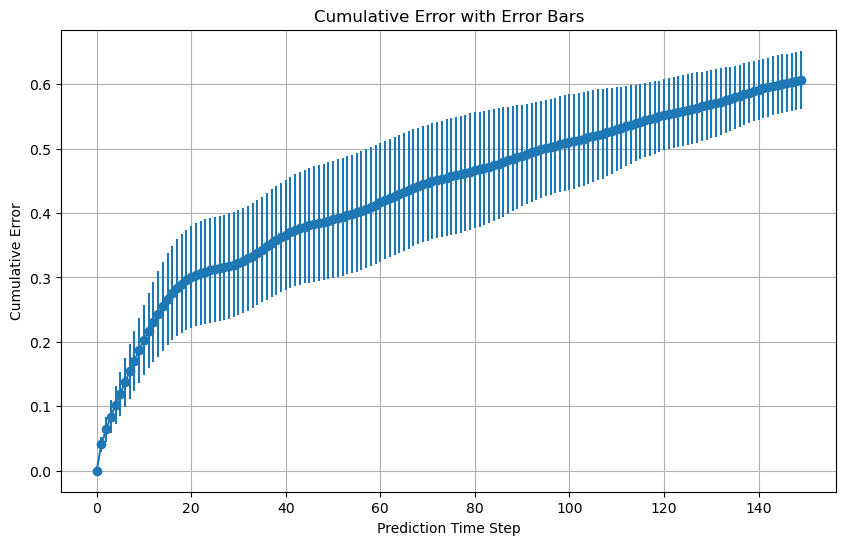

In [19]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(window_size), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
# plt.ylim(0, 0.15)
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [20]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]
print(np.mean(domain_relative_error))

0.6067450812176791


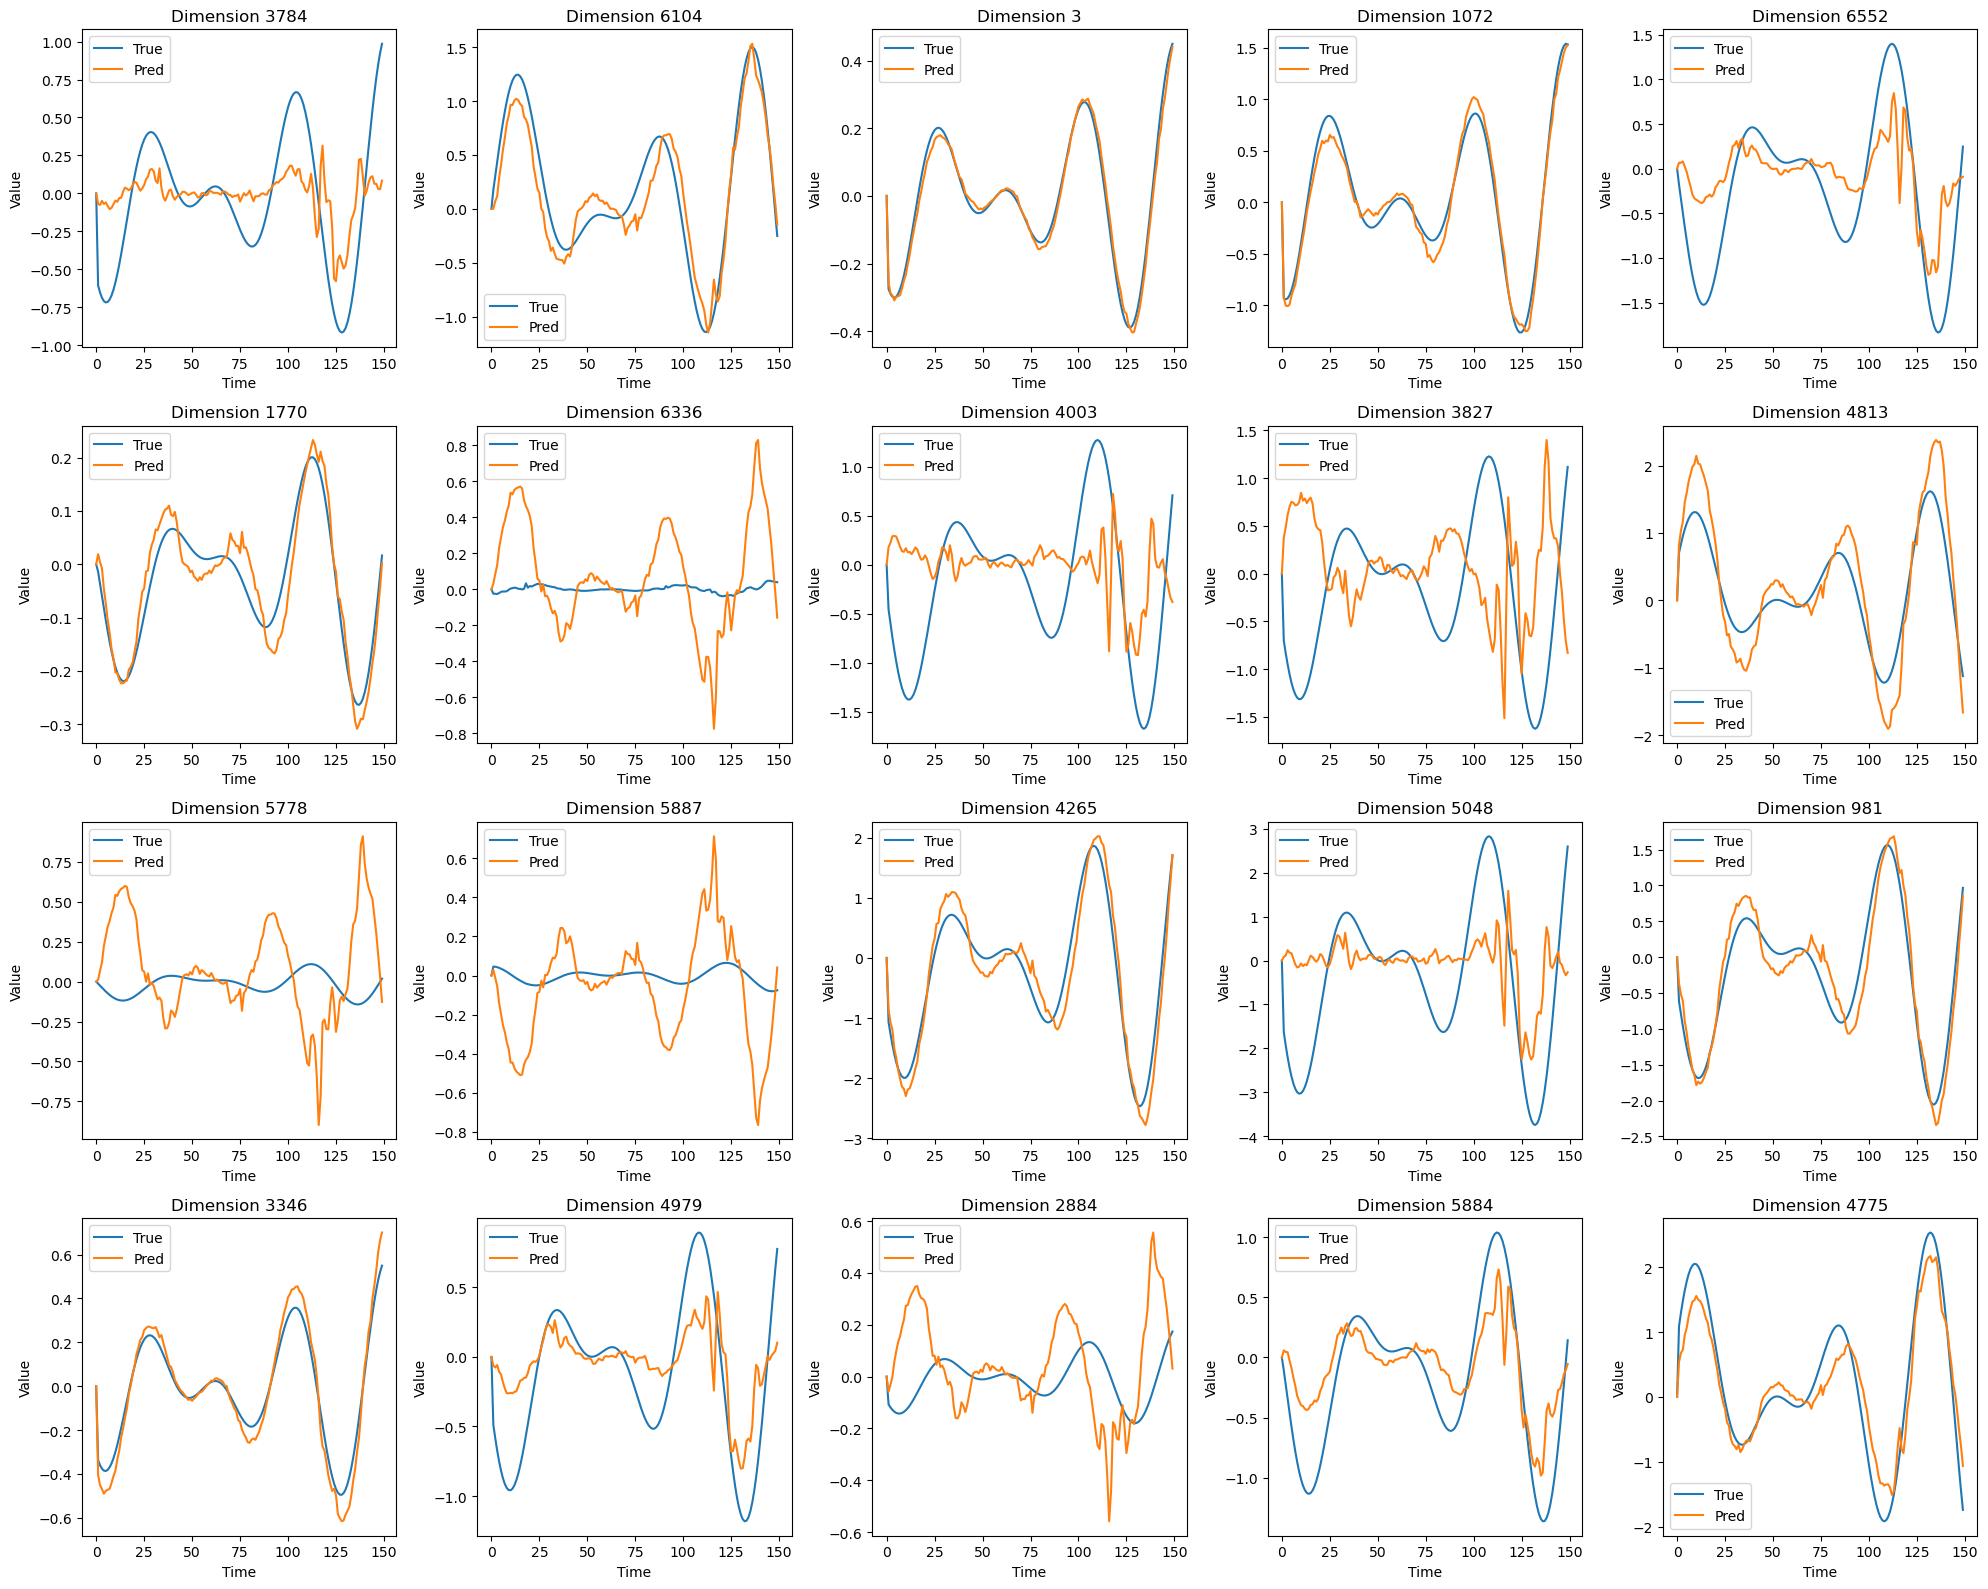

In [21]:
import numpy as np
import matplotlib.pyplot as plt

k = 0  # 假设你已经有了一个数据集索引
n_dimensions = x_dataset[k].shape[1]  # 假设x_dataset[k]是你的数据
selected_dimensions = np.random.choice(n_dimensions, 20, replace=False)  # 随机选择20个维度

# 设置一个4x5的子图网格
fig, axs = plt.subplots(4, 5, figsize=(20, 16))  # 调整figsize根据你的需求

# 确保x_true和x_pred已经根据k正确加载
x_true = x_dataset[k]
x_pred = x_data_pred_traj[k]

# 遍历所有选定的维度
for idx, dim in enumerate(selected_dimensions):
    # 计算行号和列号
    row = idx // 5
    col = idx % 5
    
    # 在对应的子图上绘图
    axs[row, col].plot(x_true[:, dim], label='True')
    axs[row, col].plot(x_pred[:, dim], label='Pred')
    axs[row, col].set_title(f'Dimension {dim}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# 调整布局以防止标签重叠
plt.tight_layout()
plt.show()


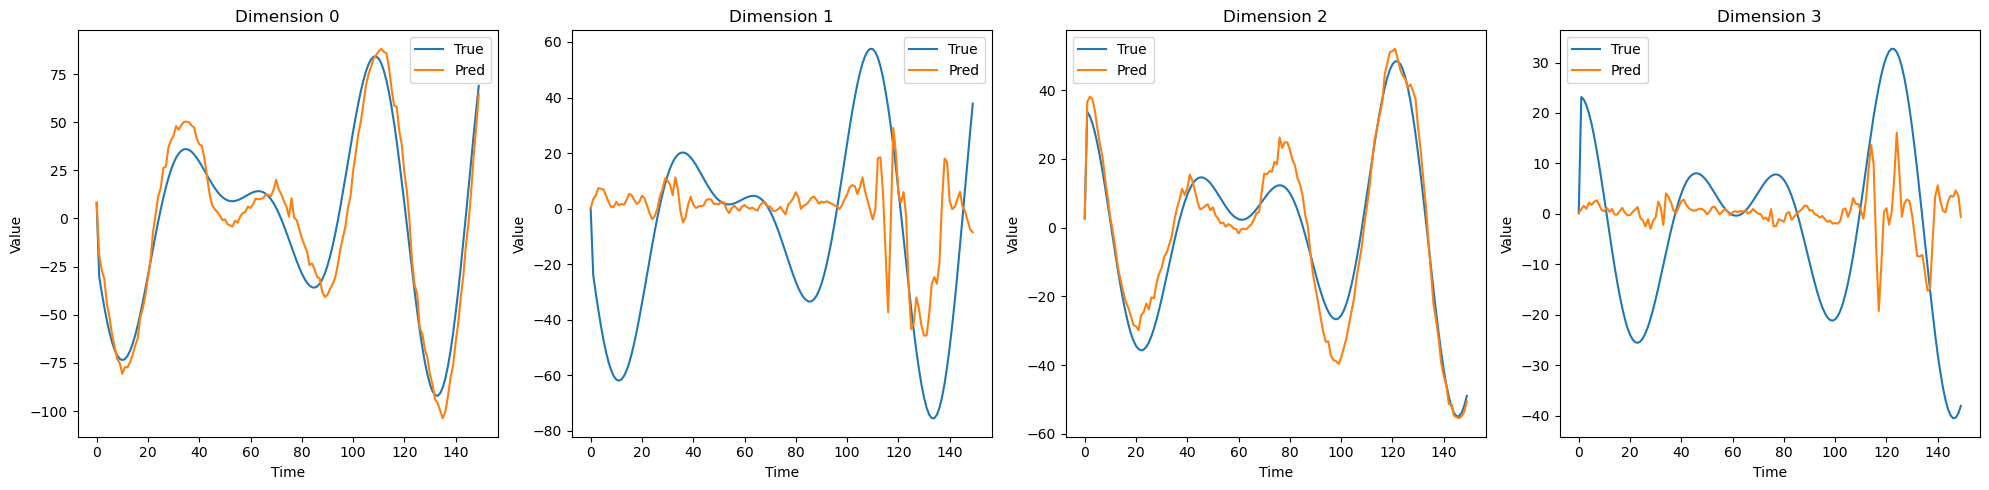

In [22]:
import numpy as np
import matplotlib.pyplot as plt

k = 0  # 假设这是你想要绘图的数据集的索引

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 创建一个1行4列的子图布局

# 假设 x_data_pca_traj 和 x_data_pca_pred_traj 已经是你加载的数据
x_true = x_data_pca_traj[k]
x_pred = x_data_pca_pred_traj[k]

# 遍历前4个维度进行绘图
for dim in range(4):
    # 直接使用dim作为列索引，因为只有一行
    axs[dim].plot(x_true[:, dim], label='True')  # 绘制真实值
    axs[dim].plot(x_pred[:, dim], label='Pred')  # 绘制预测值
    axs[dim].set_title(f'Dimension {dim}')  # 设置标题
    axs[dim].set_xlabel('Time')  # 设置x轴标签
    axs[dim].set_ylabel('Value')  # 设置y轴标签
    axs[dim].legend()  # 显示图例

plt.tight_layout()  # 调整布局
plt.show()  # 显示图形

In [23]:
errors_pca = [x_data_pca_pred_traj[i] - x_data_pca_traj[i] for i in range(len(x_data_pca_pred_traj))]

cumulative_error_norms_pca = []
for k in range(4):
    cur_dim_norm = np.array([np.array([np.linalg.norm(errors_pca[i][:j+1,k]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))])
    cumulative_error_norms_pca.append(cur_dim_norm)




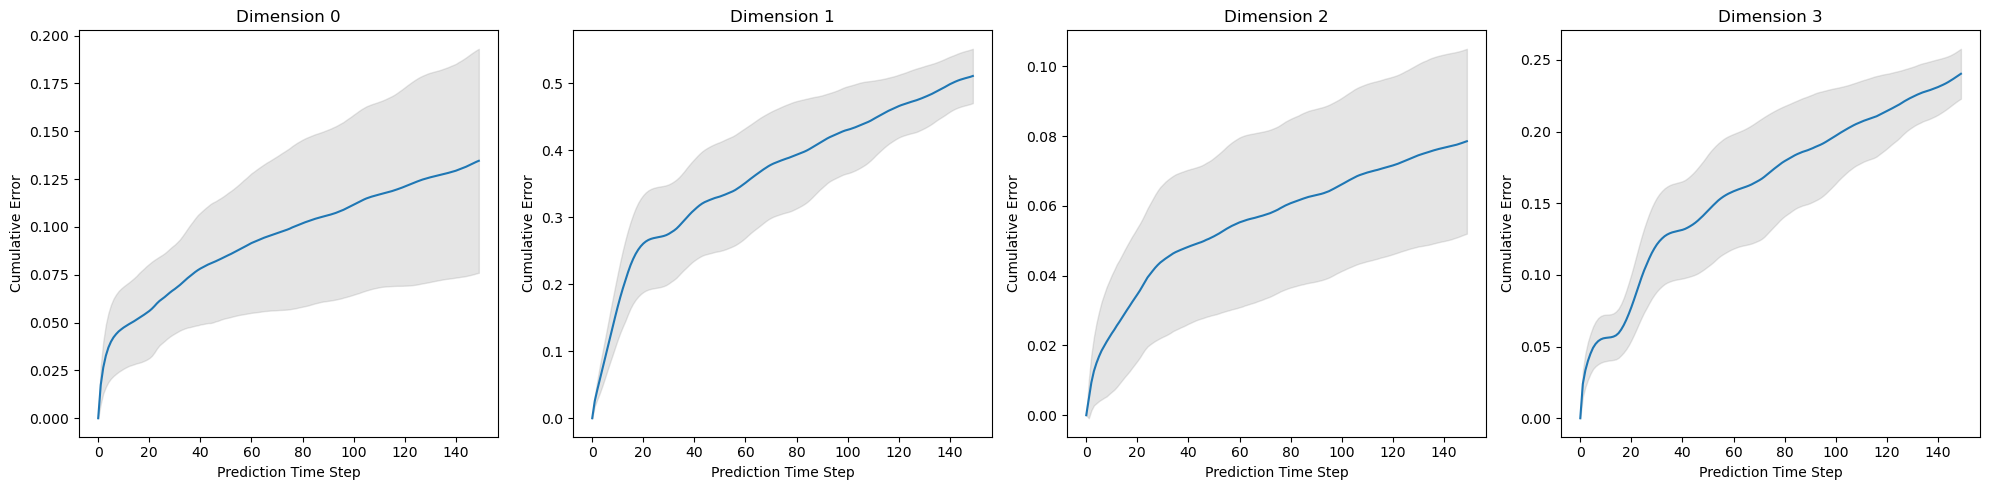

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 window_size, cumulative_error_norms_pca, x_data_pca_traj 等变量已经定义

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 创建一个1行4列的子图布局

for dim in range(4):
    # 计算平均相对误差和标准差
    mean_relative_errors_pca = np.mean([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_data_pca_traj[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)
    std_relative_errors_pca = np.std([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_data_pca_traj[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)

    # 计算上下误差界限
    upper_bound = mean_relative_errors_pca + std_relative_errors_pca
    lower_bound = mean_relative_errors_pca - std_relative_errors_pca

    # 绘制平均误差曲线
    axs[dim].plot(range(window_size), mean_relative_errors_pca, '-', label='Mean Cumulative Error')
    
    # 使用阴影表示误差范围
    axs[dim].fill_between(range(window_size), lower_bound, upper_bound, color='gray', alpha=0.2)

    axs[dim].set_xlabel('Prediction Time Step')
    axs[dim].set_ylabel('Cumulative Error')
    axs[dim].set_title(f'Dimension {dim}')

plt.tight_layout()
plt.show()
